In [1]:
from utils.dataset import FlowersDataset, get_ae_transforms
from models.autoencoder import ConvAutoencoder
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = FlowersDataset("../data/processed/train", transform=get_ae_transforms())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

model = ConvAutoencoder(latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
history = []

for epoch in range(epochs):
    running_loss = 0
    model.train()

    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")


Epoch 1/30 | Loss: 0.0479
Epoch 2/30 | Loss: 0.0307
Epoch 3/30 | Loss: 0.0257
Epoch 4/30 | Loss: 0.0223
Epoch 5/30 | Loss: 0.0205
Epoch 6/30 | Loss: 0.0190
Epoch 7/30 | Loss: 0.0178
Epoch 8/30 | Loss: 0.0172
Epoch 9/30 | Loss: 0.0165
Epoch 10/30 | Loss: 0.0157
Epoch 11/30 | Loss: 0.0153
Epoch 12/30 | Loss: 0.0148
Epoch 13/30 | Loss: 0.0144
Epoch 14/30 | Loss: 0.0140
Epoch 15/30 | Loss: 0.0137
Epoch 16/30 | Loss: 0.0133
Epoch 17/30 | Loss: 0.0129
Epoch 18/30 | Loss: 0.0127
Epoch 19/30 | Loss: 0.0123
Epoch 20/30 | Loss: 0.0121
Epoch 21/30 | Loss: 0.0121
Epoch 22/30 | Loss: 0.0116
Epoch 23/30 | Loss: 0.0112
Epoch 24/30 | Loss: 0.0109
Epoch 25/30 | Loss: 0.0107
Epoch 26/30 | Loss: 0.0107
Epoch 27/30 | Loss: 0.0104
Epoch 28/30 | Loss: 0.0100
Epoch 29/30 | Loss: 0.0099
Epoch 30/30 | Loss: 0.0100


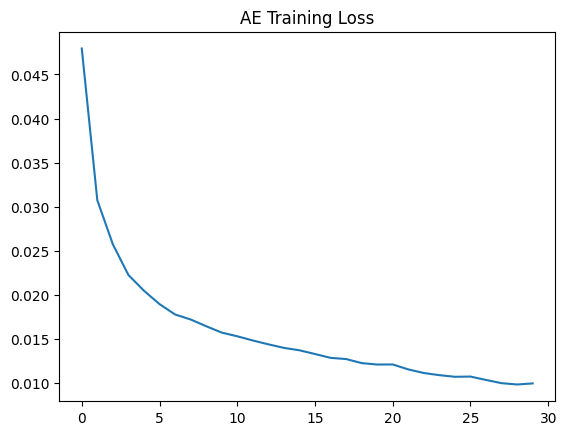

In [5]:
plt.plot(history)
plt.title("AE Training Loss")
plt.savefig("../results/ae_trainloss.png", dpi=300)
plt.show()

### Застосування автоенкодера

детектор аномалій

In [6]:
# anomaly detect
import torch.nn.functional as F

errors = []
images_list = []

model.eval()
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, _ = model(x)

        loss = F.mse_loss(x_hat, x, reduction='none')
        loss = loss.mean(dim=[1,2,3])

        errors.extend(loss.cpu().numpy())
        images_list.extend(x.cpu())

# сортуємо від найбільшої похибки
import numpy as np
idx = np.argsort(errors)[-5:]  # топ 5 аномалій


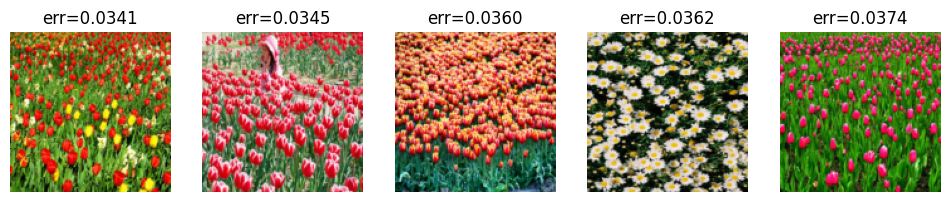

In [7]:
plt.figure(figsize=(12,6))
for i, index in enumerate(idx):
    plt.subplot(1,5,i+1)
    img = images_list[index].permute(1,2,0)
    plt.imshow(img)
    plt.title(f"err={errors[index]:.4f}")
    plt.axis("off")
plt.savefig("../results/ae_anomalies.png", dpi=300)
plt.show()

денойзинг

In [9]:
def add_noise(x, noise_level=0.2):
    noise = torch.randn_like(x) * noise_level
    x_noisy = x + noise
    x_noisy = torch.clamp(x_noisy, 0., 1.)
    return x_noisy

In [10]:
# 1 batch
model.eval()
x_batch, _ = next(iter(train_loader))
x_batch = x_batch.to(device)

with torch.no_grad():
    x_noisy = add_noise(x_batch)
    x_denoised, _ = model(x_noisy)

x_batch = x_batch.cpu()
x_noisy = x_noisy.cpu()
x_denoised = x_denoised.cpu()

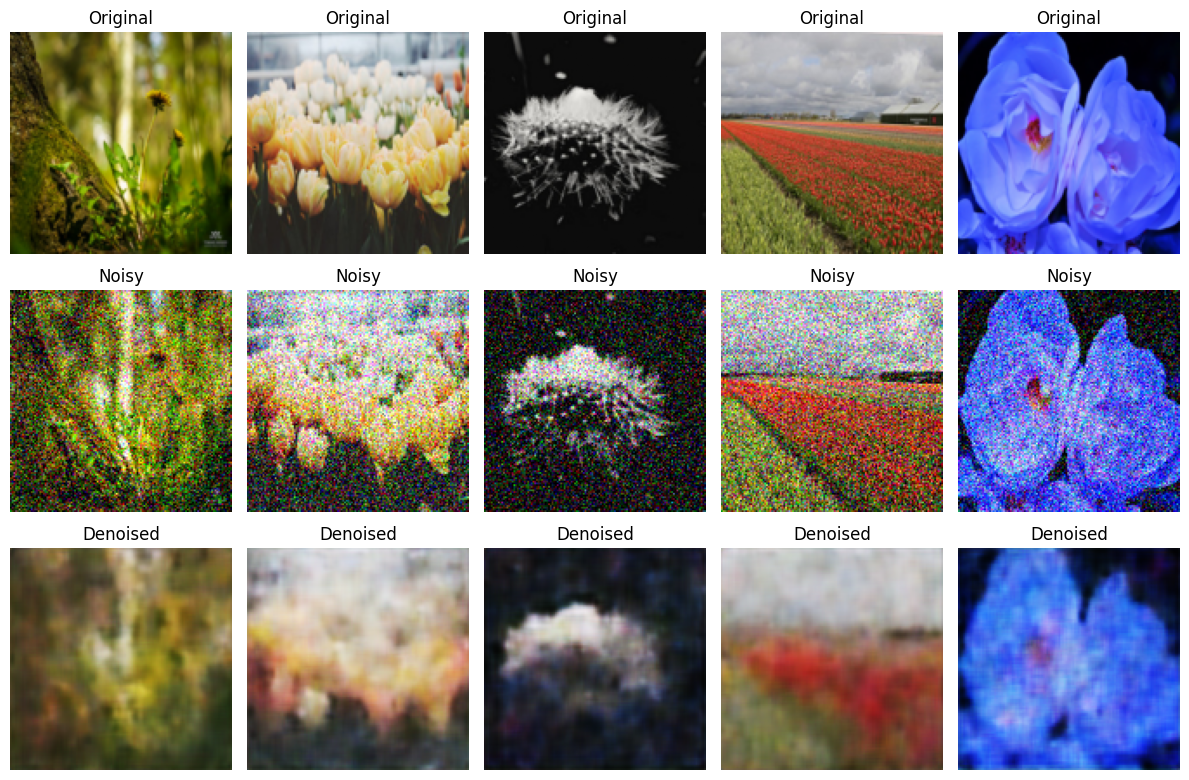

In [11]:
plt.figure(figsize=(12, 8))

for i in range(5):
    # og
    plt.subplot(3,5,i+1)
    plt.imshow(x_batch[i].permute(1,2,0))
    plt.title("Original")
    plt.axis("off")

    # noised
    plt.subplot(3,5,5+i+1)
    plt.imshow(x_noisy[i].permute(1,2,0))
    plt.title("Noisy")
    plt.axis("off")

    # denoised
    plt.subplot(3,5,10+i+1)
    plt.imshow(x_denoised[i].permute(1,2,0))
    plt.title("Denoised")
    plt.axis("off")

plt.tight_layout()
plt.savefig("../results/ae_noiz.png", dpi=300)
plt.show()